In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import rankdata
# import theano.tensor as T 
# from theano.compile.ops import as_op
%matplotlib inline

colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

name = "Linear SVM"

clf = SVC(kernel="linear", C=0.025)

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

pair_list = [(0,1),(1,2),(0,2)]
for pair,i in zip(pair_list,range(3)):

    clf.fit(X_train,y_train)
    y_score = clf.decision_function(X_test)
    pos_score = y_score[y_test==1]
    neg_score = y_score[y_test==0]
    alldata = np.concatenate((pos_score , neg_score))
    ranked = rankdata(alldata)
    m1 = len(pos_score)
    m2 = len(neg_score)
    pos_rank = ranked[:m1]
    neg_rank = ranked[m1:]
    s = np.sum(pos_rank,axis=0)
    count = s - m1*(m1+1)/2.0

    clf = SVC(gamma=2, C=1)
    clf.fit(X_train,y_train)
    y_score = clf.decision_function(X_test)
    pos_score = y_score[y_test==1]
    neg_score = y_score[y_test==0]
    alldata = np.concatenate((pos_score , neg_score))
    ranked = rankdata(alldata)
    m1 = len(pos_score)
    m2 = len(neg_score)
    pos_rank = ranked[:m1]
    neg_rank = ranked[m1:]
    s2 = np.sum(pos_rank,axis=0)
    count2 = s2 - m1*(m1+1)/2.0

@as_op(itypes=[T.dscalar,T.dscalar], otypes=[T.dscalar])
def delta(v1,v2):
    return (v1-v2)

# Binomal-Beta Conjugate
sample = 20000
with pm.Model() as model:
    p = pm.Beta('p',alpha=1,beta=1)
    n = pm.Binomial('n',n=m1*m2,p=p,observed=count)
    p2 = pm.Beta('p2',alpha=1,beta=1)
    n2 = pm.Binomial('n2',n=m1*m2,p=p2,observed=count2)
    d  = delta(p,p2)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(sample, step, start=start, progressbar=True)


Applied logodds-transform to p and added transformed p_logodds to model.
Applied logodds-transform to p2 and added transformed p2_logodds to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.0 sec

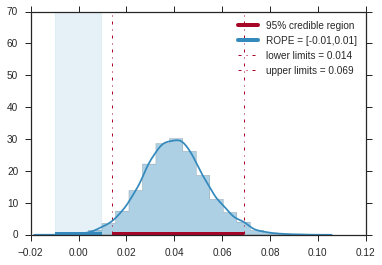

In [22]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sns.set_style('ticks')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
delta = trace['p']-trace['p2']
lower_limits = np.round(np.sort(delta)[int(0.025 * sample)],decimals=3)
upper_limits = np.round(np.sort(delta)[int(0.975 * sample)],decimals=3)
ax = plt.subplot()
vlines_height = 70
_ = ax.hlines(0.1, lower_limits, upper_limits, label="95% credible region",
           color=colors[1], linewidths=4)
_ = ax.set_ylim(0,70)
_ = ax.hlines(0.1, -0.01, 0.01, label='ROPE = [-0.01,0.01]',
           color=colors[0], linewidths=4)
_ = ax.add_patch(patches.Rectangle((-0.01,0.1),0.02,70,color=colors[9],alpha = 0.1,))
_ = ax.vlines(lower_limits,  0.1, vlines_height, label="lower limits = {0:0.3f}".format(lower_limits),
           linestyles="-.", color=colors[1], linewidths=1)
_ = ax.vlines(upper_limits,  0.1, vlines_height, label="upper limits = {0:0.3f}".format(upper_limits),
           linestyles="-.", color=colors[1], linewidths=1)
_ = ax.legend()
_ = ax.set_title()
sns.distplot(delta,bins=20,color=colors[0],hist_kws={"histtype": "stepfilled"})
plt.show()

In [28]:
pair_list = [(0,1),(1,2),(0,2)]
for pair,i in zip(pair_list,range(3)):
    print pair[0]

0
1
0
